In [112]:
'''Simple implementation of naive NUTS on the banana distribution'''

import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

In [113]:
b = 5
sigma = 1
def log_P(X:jnp.array):
    return (-(X[...,0]**2 + (X[...,1]- b * (X[...,0]**2 - sigma**2)))**2)/2

grad_V = jax.jit(jax.grad(lambda x: -log_P(x)))

In [114]:
@jax.jit 
def Leapfrog(theta,r,veps): 
    r = r - (veps / 2) * grad_V(theta)
    theta = theta + veps * r
    r = r - (veps / 2) * grad_V(theta)

    return theta,r

In [115]:
delta_max = 50

def BuildTree(theta,r,u,v,j,epsilon): 
    if j == 0: 
        ### Base case - take one leapfrog step
        theta_prime,r_prime = Leapfrog(theta,r,v*epsilon)

        C_prime = []
        if u <= jnp.exp(log_P(theta_prime) - 1/2 * jnp.dot(r_prime,r_prime)): 
            C_prime.append((theta_prime,r_prime))

        s_prime = 0
        if (log_P(theta_prime) - 1/2 * jnp.dot(r_prime,r_prime)) > (jnp.log(u) - delta_max):
            s_prime = 1

        return theta_prime,r_prime,theta_prime,r_prime,C_prime,s_prime
    
    else: 
        ### Recursion - build the left and right subtrees
        theta_minus,r_minus,theta_plus,r_plus,C_prime,s_prime = BuildTree(theta,r,u,v,j-1,epsilon)

        if v == -1: 
            theta_minus,r_minus,_,_,C_prime2,s_prime2 = BuildTree(theta_minus,r_minus,u,v,j-1,epsilon)
        else: 
            _,_,theta_plus,r_plus,C_prime2,s_prime2 = BuildTree(theta_plus,r_plus,u,v,j-1,epsilon)

        cond1 = 1 if ((theta_plus - theta_minus).T @ r_minus >= 0) else 0
        cond2 = 1 if ((theta_plus - theta_minus).T @ r_plus >= 0) else 0

        s_prime = s_prime * s_prime2 * cond1 * cond2
        C_prime = C_prime + C_prime2

        return theta_minus, r_minus , theta_plus, r_plus, C_prime, s_prime

In [ ]:
iterations = 500
step_size = 0.001
thetas = jnp.zeros((iterations,2))

rng_key = jax.random.key(0)

for iteration in range(1,iterations): 

    ##Initialization 
    rng_key,r_key = jax.random.split(rng_key)
    r_0 = jax.random.normal(r_key,shape = (2,))
    rng_key,u_key = jax.random.split(rng_key)
    u = jax.random.uniform(u_key,minval = 0.,maxval = jnp.exp(log_P(thetas[iteration-1,:]) - 1/2 * jnp.dot(r_0,r_0)))

    theta_minus = thetas[iteration-1,:]
    r_minus = r_0

    theta_plus = thetas[iteration-1,:]
    r_plus = r_0

    j = 0
    s = 1

    C = [(thetas[iteration-1,:],r_0)]

    while s == 1:
        rng_key,direction_key = jax.random.split(rng_key)
        v_j =  jax.random.choice(direction_key,jnp.array([-1,1]))

        if v_j == -1: 
            theta_minus, r_minus, _,_,C_prime, s_prime = BuildTree(theta_minus,r_minus,u,v_j,j,step_size)
        else: 
            _, _, theta_plus,r_plus,C_prime, s_prime = BuildTree(theta_plus,r_plus,u,v_j,j,step_size)

        if s_prime == 1: 
            C = C + C_prime
        
        cond1 = 1 if ((theta_plus - theta_minus).T @ r_minus >= 0) else 0
        cond2 = 1 if ((theta_plus - theta_minus).T @ r_plus >= 0) else 0

        s = s_prime * cond1 * cond2
        j = j+1

    rng_key,sample_key = jax.random.split(rng_key)
    choice_index = jax.random.choice(sample_key,a = len(C))

    theta_new = C[choice_index]
    thetas = thetas.at[iteration,:].set(theta_new[0])

    print(f"Iteration {iteration} with proposal: {theta_new[0]}",end = '\r')

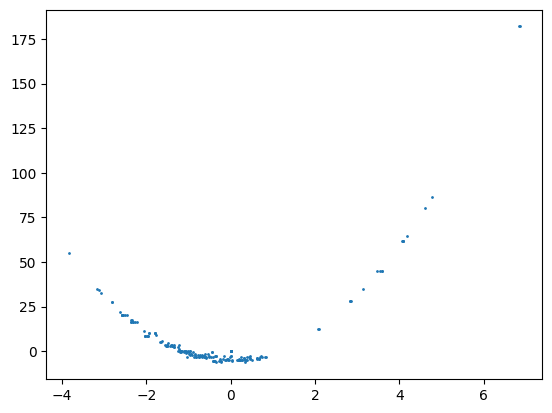

In [ ]:
plt.scatter(thetas[:,0],thetas[:,1],s=1.)